### Feature Engineering & Feature Selection
https://towardsdatascience.com/feature-engineering-feature-selection-8c1d57af18d2

In [1]:
#import all the libraries
import pandas as pd
import numpy as np
import seaborn as sns 
import yfinance as yf  #the stock data from Yahoo Finance
import matplotlib.pyplot as plt #set the parameters for plotting
plt.style.use('seaborn')
plt.rcParams['figure.dpi'] = 300
#define a function to get data
def get_data(symbols, begin_date=None,end_date=None):
    df = yf.download('AAPL', start = '2000-01-01',
                     auto_adjust=True,#only download adjusted data
                     end= '2010-12-31') 
    #my convention: always lowercase
    df.columns = ['open','high','low',
                  'close','volume'] 
    
    return df
prices = get_data('AAPL', '2000-01-01', '2010-12-31')   
prices.head()

[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
Date,,,,,
2000-01-03,0.805199,0.863742,0.780726,0.859423,535796800
2000-01-04,0.831112,0.849346,0.776888,0.786965,512377600
2000-01-05,0.796562,0.848866,0.790804,0.798481,778321600
2000-01-06,0.814797,0.821514,0.729382,0.729382,767972800
2000-01-07,0.740898,0.775448,0.733221,0.763932,460734400


In [11]:
(0.786965 - 0.859423)/0.786965

-0.0920727097139009

In [3]:
def price_spread(df):
    return (df.high - df.low)

def close_location(df):
    return (df.high - df.close) / (df.high - df.low)
# Zero indicates the close is the high of the day, and 1 means close 
#is the low of the day and the smaller the value, the closer the #close price to the high. 


# Now comes the tricky part,
# “When viewed in a larger context, some of the price bars take on a new meaning.”
# That means to see the full pictures, we need to observe those 4 basic features under a different time scale.
# To do that, we need to reconstruct a High(H), Low(L), Close(C) and Volume(V) bar at varied time span.
def create_HLCV(i): 
    """
    i: days
    as we don't care about open that much, that leaves volume, 
    high,low and close
    """

    df = pd.DataFrame(index=prices.index)
    df[f'high_{i}D'] = prices.high.rolling(i).max()
    df[f'low_{i}D'] = prices.low.rolling(i).min()
    df[f'close_{i}D'] = prices.close.rolling(i).\
                        apply(lambda x:x[-1]) 
    # close_2D = close as rolling backwards means today is 
    #literally, the last day of the rolling window.
    df[f'volume_{i}D'] = prices.volume.rolling(i).sum()
    
    return df


# next step, create those 4 basic features based on a different time scale.
def create_features(i):
    df = create_HLCV(i)
    high = df[f'high_{i}D']
    low = df[f'low_{i}D']
    close = df[f'close_{i}D']
    volume = df[f'volume_{i}D']
    
    features = pd.DataFrame(index=prices.index)
    features[f'volume_{i}D'] = volume
    features[f'price_spread_{i}D'] = high - low
    features[f'close_loc_{i}D'] = (high - close) / (high - low)
    features[f'close_change_{i}D'] = close.diff()
    
    return features

In [15]:
prices

,open,high,low,close,volume
Date,,,,,
2000-01-03,0.805199,0.863742,0.780726,0.859423,535796800
2000-01-04,0.831112,0.849346,0.776888,0.786965,512377600
2000-01-05,0.796562,0.848866,0.790804,0.798481,778321600
2000-01-06,0.814797,0.821514,0.729382,0.729382,767972800
2000-01-07,0.740898,0.775448,0.733221,0.763932,460734400
...,...,...,...,...,...
2010-12-23,9.981013,9.985619,9.924812,9.938018,223157200
2010-12-27,9.914985,9.994525,9.874139,9.971185,249816000
2010-12-28,10.008965,10.031998,9.982862,9.995453,175924000


In [12]:
create_HLCV(3)

,high_3D,low_3D,close_3D,volume_3D
Date,,,,
2000-01-03,NaN,NaN,NaN,NaN
2000-01-04,NaN,NaN,NaN,NaN
2000-01-05,0.863742,0.776888,0.798481,1.826496e+09
2000-01-06,0.849346,0.729382,0.729382,2.058672e+09
2000-01-07,0.848866,0.729382,0.763932,2.007029e+09
...,...,...,...,...
2010-12-23,10.003128,9.890419,9.938018,7.454328e+08
2010-12-27,10.003128,9.874139,9.971185,7.388948e+08
2010-12-28,10.031998,9.874139,9.995453,6.488972e+08


The time spans that I would like to explore are 1, 2, 3 days and 1 week, 1 month, 2 months, 3 months, which roughly are [1,2,3,5,20,40,60] days. Now, we can create a whole bunch of features,

In [4]:
def create_bunch_of_features():
    days = [1,2,3,5,20,40,60]
    bunch_of_features = pd.DataFrame(index=prices.index)
    for day in days:
        f = create_features(day)
        bunch_of_features = bunch_of_features.join(f)
    
    return bunch_of_features

bunch_of_features = create_bunch_of_features()
bunch_of_features.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2766 entries, 2000-01-03 to 2010-12-30
Data columns (total 28 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   volume_1D         2766 non-null   float64
 1   price_spread_1D   2766 non-null   float64
 2   close_loc_1D      2766 non-null   float64
 3   close_change_1D   2765 non-null   float64
 4   volume_2D         2765 non-null   float64
 5   price_spread_2D   2765 non-null   float64
 6   close_loc_2D      2765 non-null   float64
 7   close_change_2D   2764 non-null   float64
 8   volume_3D         2764 non-null   float64
 9   price_spread_3D   2764 non-null   float64
 10  close_loc_3D      2764 non-null   float64
 11  close_change_3D   2763 non-null   float64
 12  volume_5D         2762 non-null   float64
 13  price_spread_5D   2762 non-null   float64
 14  close_loc_5D      2762 non-null   float64
 15  close_change_5D   2761 non-null   float64
 16  volume_20D        2747 n

In [6]:
bunch_of_features.head(3)

,volume_1D,price_spread_1D,close_loc_1D,close_change_1D,volume_2D,price_spread_2D,close_loc_2D,close_change_2D,volume_3D,price_spread_3D,...,close_loc_20D,close_change_20D,volume_40D,price_spread_40D,close_loc_40D,close_change_40D,volume_60D,price_spread_60D,close_loc_60D,close_change_60D
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,535796800.0,0.083015,0.052020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,512377600.0,0.072458,0.860924,-0.072458,1.048174e+09,0.086854,0.883975,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,778321600.0,0.058062,0.867776,0.011516,1.290699e+09,0.072458,0.701991,0.011516,1.826496e+09,0.086854,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# next day's returns as outcomes
outcomes = pd.DataFrame(index=prices.index)
outcomes['close_1'] = prices.close.pct_change(-1)
outcomes.head(3)

,close_1
Date,
2000-01-03,0.092073
2000-01-04,-0.014422
2000-01-05,0.094737


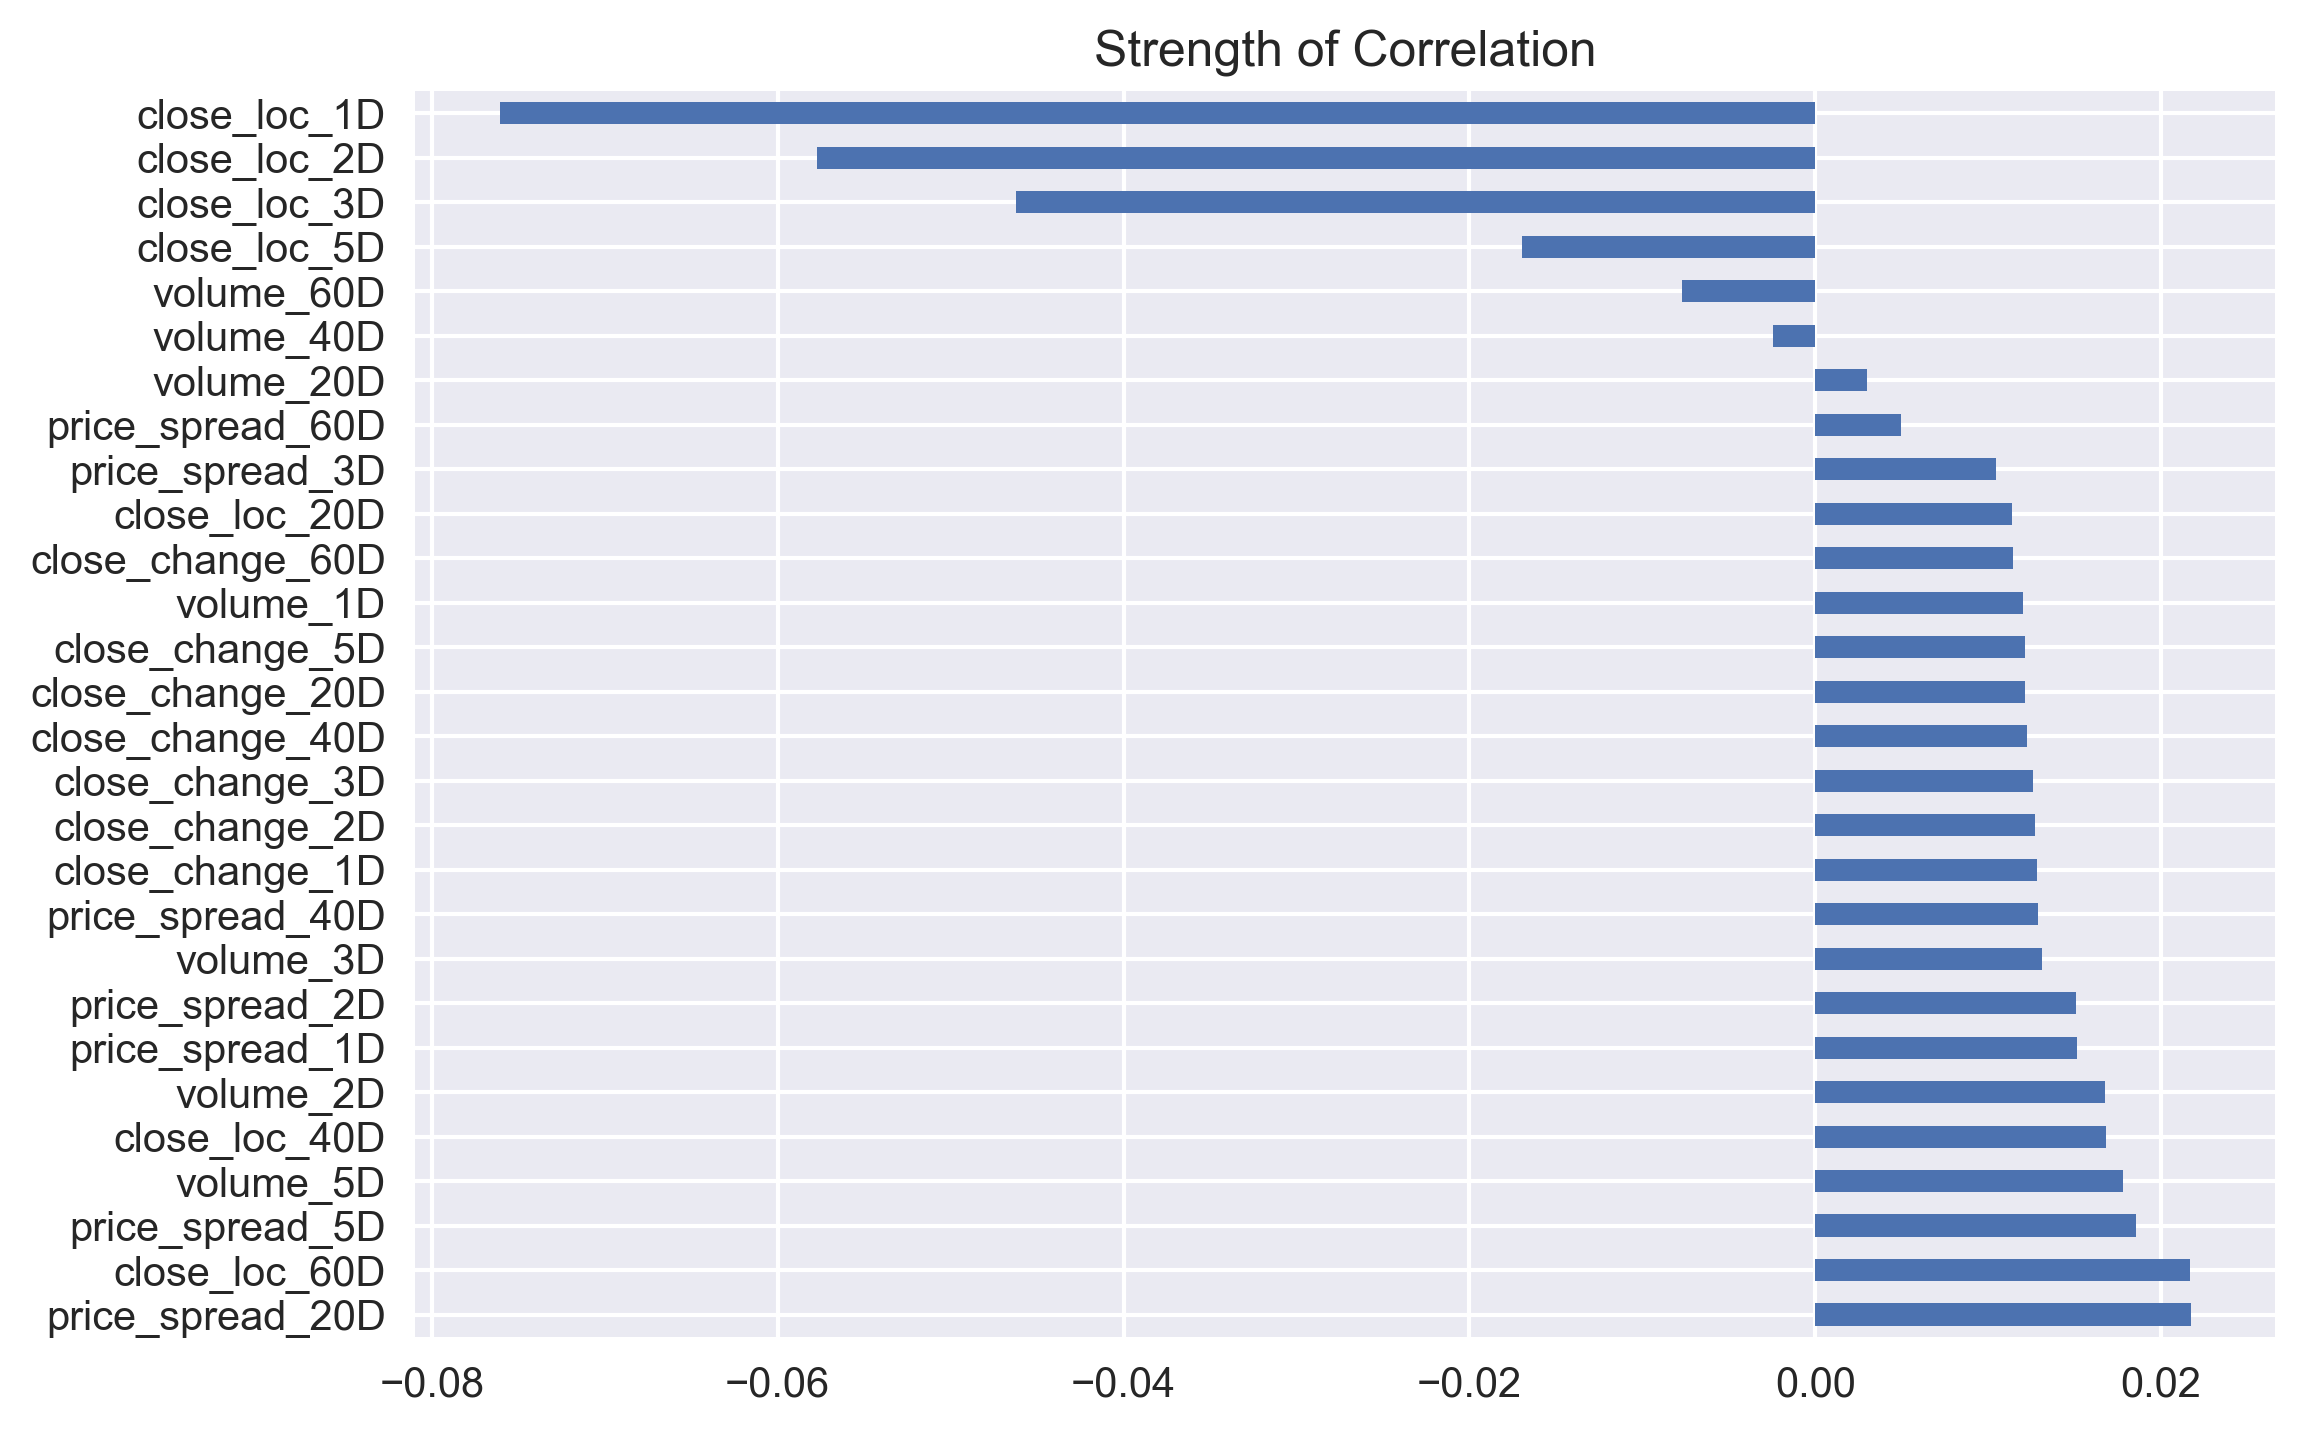

In [8]:
corr = bunch_of_features.corrwith(outcomes.close_1)
corr.sort_values(ascending=False).plot.barh(title = 'Strength of Correlation');

In [17]:
def create_features_v1(i):
    df = create_HLCV(i)
    high = df[f'high_{i}D']
    low = df[f'low_{i}D']
    close = df[f'close_{i}D']
    volume = df[f'volume_{i}D']
    
    features = pd.DataFrame(index=prices.index)
    features[f'volume_{i}D'] = volume
    features[f'price_spread_{i}D'] = high - low
    features[f'close_loc_{i}D'] = (high - close) / (high - low)
    #only change here
    features[f'close_change_{i}D'] = close.pct_change()
    
    return features

def create_bunch_of_features_v1():
    days = [1,2,3,5,20,40,60]
    bunch_of_features = pd.DataFrame(index=prices.index)
    for day in days:
        f = create_features_v1(day)#here is the only difference
        bunch_of_features = bunch_of_features.join(f)
    
    return bunch_of_features

bunch_of_features_v1 = create_bunch_of_features_v1()
bunch_of_features_v1.head(4)

,volume_1D,price_spread_1D,close_loc_1D,close_change_1D,volume_2D,price_spread_2D,close_loc_2D,close_change_2D,volume_3D,price_spread_3D,...,close_loc_20D,close_change_20D,volume_40D,price_spread_40D,close_loc_40D,close_change_40D,volume_60D,price_spread_60D,close_loc_60D,close_change_60D
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,535796800.0,0.083015,0.052020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-04,512377600.0,0.072458,0.860924,-0.084310,1.048174e+09,0.086854,0.883975,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-05,778321600.0,0.058062,0.867776,0.014633,1.290699e+09,0.072458,0.701991,0.014633,1.826496e+09,0.086854,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2000-01-06,767972800.0,0.092133,1.000000,-0.086538,1.546294e+09,0.119484,1.000000,-0.086538,2.058672e+09,0.119964,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:title={'center':'Strength of Correlation'}>

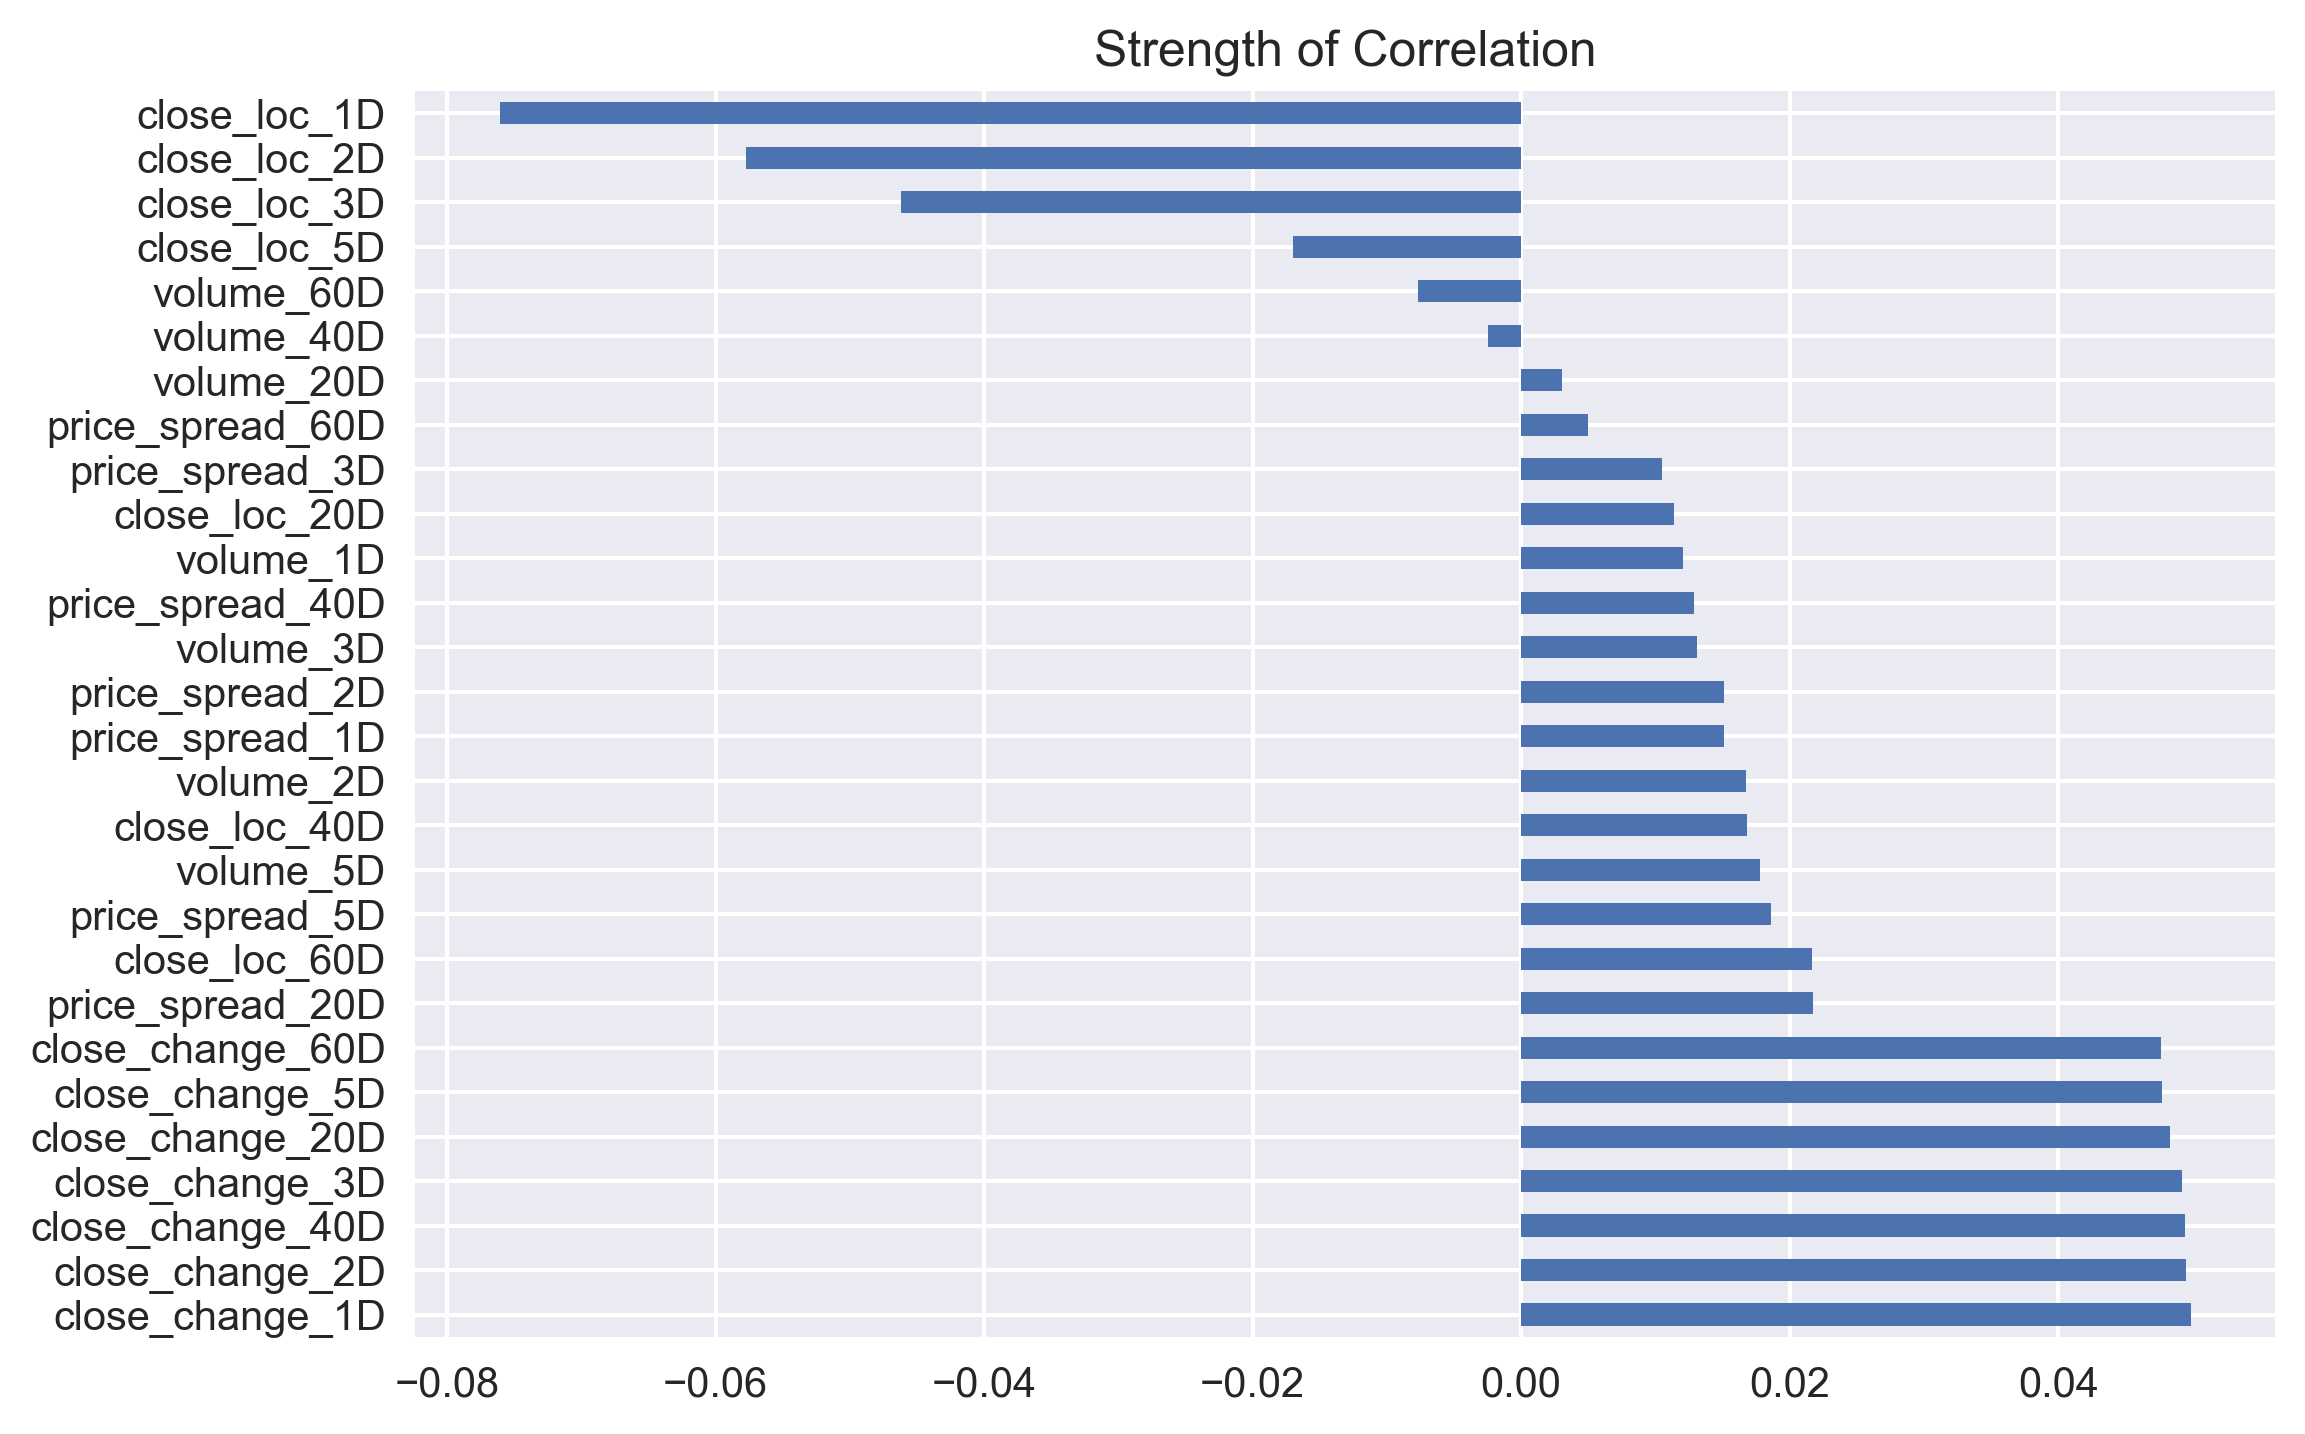

In [18]:
# check the correlation
corr_v1 = bunch_of_features_v1.corrwith(outcomes.close_1)
corr_v1.sort_values(ascending=False).plot.barh( title = 'Strength of Correlation')

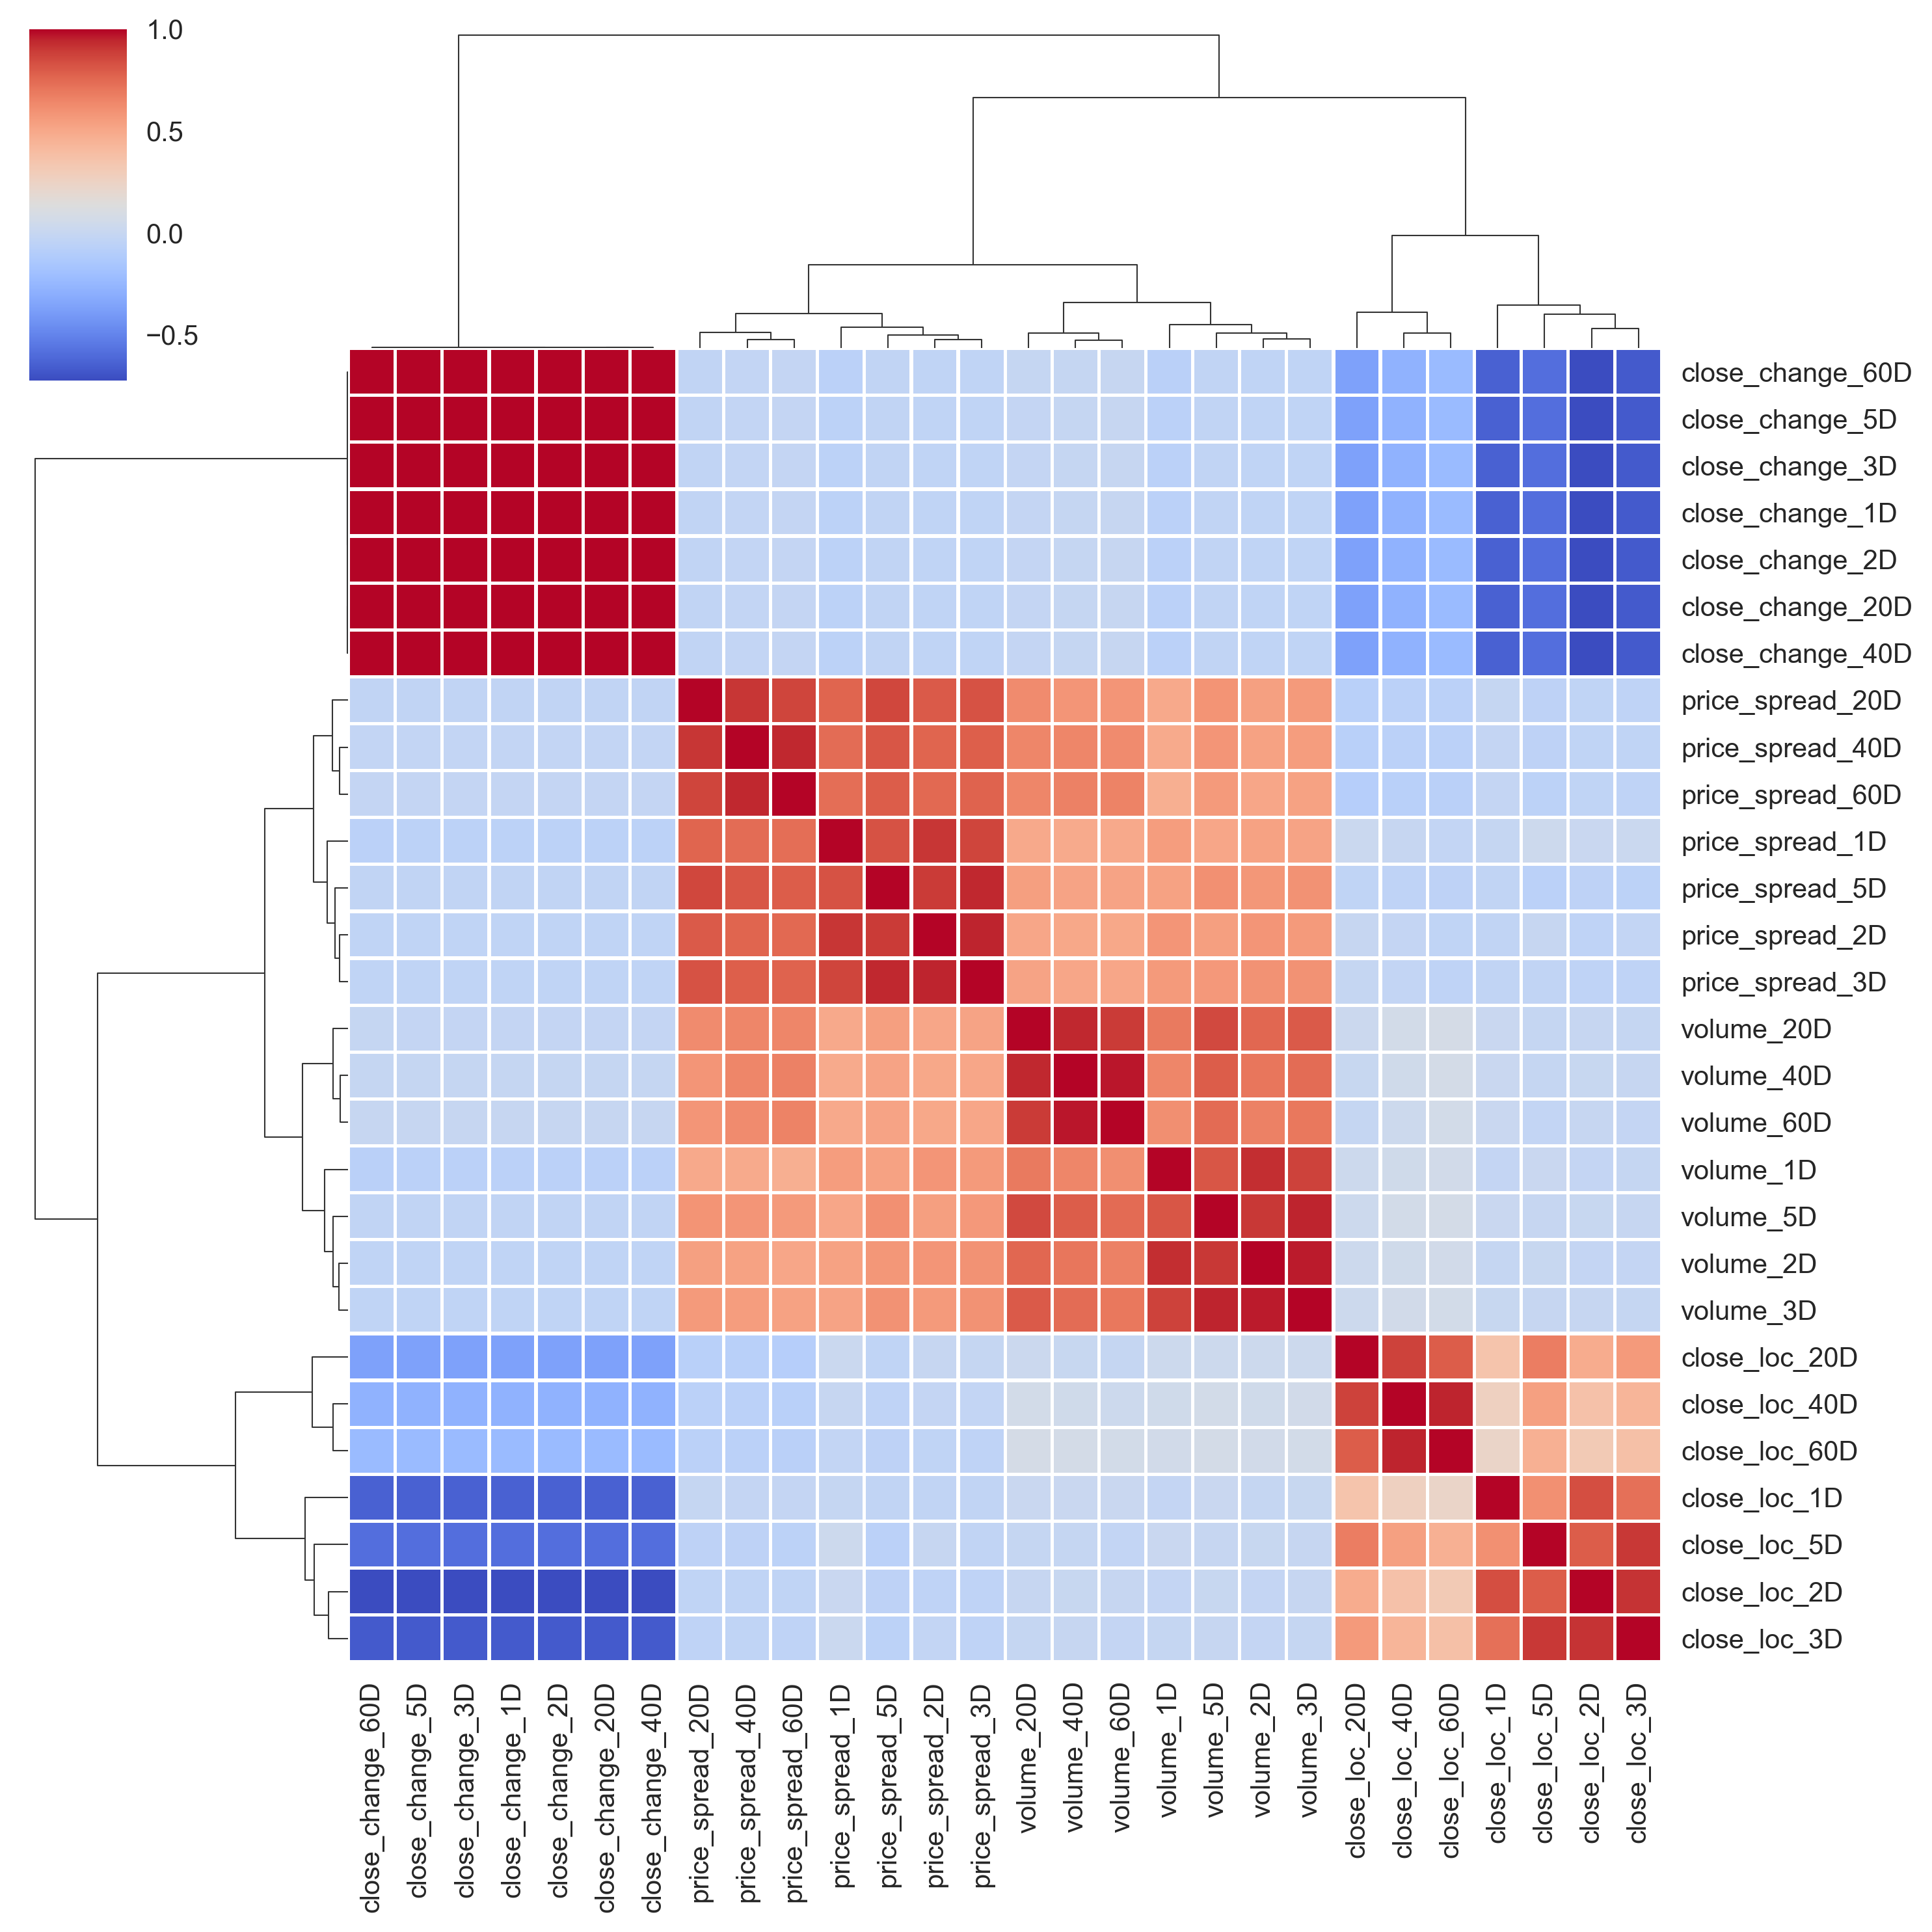

In [19]:
corr_matrix_v1 = bunch_of_features_v1.corr()
sns.clustermap(corr_matrix_v1, cmap='coolwarm', linewidth=1)